<a href="https://colab.research.google.com/github/Sandermi99/TTT4185-Machine_learning/blob/main/TTT4185_Assignment3(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TTT4185 Machine learning for Speech technology



## Part A: Classification

This assignment assumes that the student has reviewed the material on deep neural networks.

This assignment will use the [PyTorch library](https://pytorch.org/) to create neural networks.

We will be using the same, small database of phonemes from assignment 2. Each phoneme is represented by the four first formant positions ("F1"-"F4") and their corresponding bandwidths ("B1"-"B4"). All numbers are in kHz. In addition, the speaker ID and the gender of the speaker are given for each phoneme.

The first few cells of this notebook contain example code to load and extract data, setup a simple network and train a deep neural network for classification.


### Fetch data

This block will fetch the files with the formant data and prepare the data frames

In [1]:
# this will fetch the train.csv and test.csv so you do not need to manually upload them. Just run this block for each session

import pandas as pd
from sklearn.model_selection import train_test_split

! wget https://folk.ntnu.no/plparson/ttt4185_data/Train.csv
! wget https://folk.ntnu.no/plparson/ttt4185_data/Test.csv

print("Keeping ['ae', 'ey', 'ux']")

train = pd.read_csv('Train.csv')
train = train[train['Phoneme'].isin(['ae', 'ey', 'ux'])]
train.to_pickle('Train.pkl')

test = pd.read_csv('Test.csv')
test = test[test['Phoneme'].isin(['ae', 'ey', 'ux'])]
test, validation = train_test_split(test, train_size=0.5, random_state=42)
test.to_pickle('Test.pkl')
validation.to_pickle('Validation.pkl')

print('Done!')

--2025-11-10 16:23:11--  https://folk.ntnu.no/plparson/ttt4185_data/Train.csv
Resolving folk.ntnu.no (folk.ntnu.no)... 129.241.56.95, 2001:700:300:3::95
Connecting to folk.ntnu.no (folk.ntnu.no)|129.241.56.95|:443... connected.
HTTP request sent, awaiting response... 308 Permanent Redirect
Location: https://plparson.folk.ntnu.no/ttt4185_data/Train.csv [following]
--2025-11-10 16:23:11--  https://plparson.folk.ntnu.no/ttt4185_data/Train.csv
Resolving plparson.folk.ntnu.no (plparson.folk.ntnu.no)... 129.241.56.95, 2001:700:300:3::95
Connecting to plparson.folk.ntnu.no (plparson.folk.ntnu.no)|129.241.56.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2042638 (1.9M) [text/csv]
Saving to: ‘Train.csv’

Train.csv           100%[===================>]   1.95M  1.72MB/s    in 1.1s    

2025-11-10 16:23:13 (1.72 MB/s) - ‘Train.csv’ saved [2042638/2042638]

--2025-11-10 16:23:13--  https://folk.ntnu.no/plparson/ttt4185_data/Test.csv
Resolving folk.ntnu.no (folk.ntnu.no

### Setting up datasets (example)

In [2]:
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

class CustomFormantDataset(Dataset):
    def __init__(
        self,
        annotations_file,
        use_features = ['F1', 'F2'],
        phoneme_column = 'Phoneme',
        norm_data_to_mean = True
    ):
        if annotations_file[-3:] == 'pkl':
          annotations_df = pd.read_pickle(annotations_file)
        else:
          # NOTE: assuming CSV. Will throw error if another file type provided
          annotations_df = pd.read_csv(annotations_file)
        use_features = [list(annotations_df.columns).index(feat) for feat in use_features]
        # normalize the values
        scaler = StandardScaler()
        self.X_scaled = scaler.fit_transform(annotations_df.iloc[:, use_features])
        # encode our lables from human friendly to integers
        phoneme_column = list(annotations_df.columns).index(phoneme_column)
        label_encoder = LabelEncoder()
        self.integer_encoded = label_encoder.fit_transform(annotations_df.iloc[:, phoneme_column])

    def __len__(self):
        return len(self.X_scaled)

    def __getitem__(self, idx):
        label = self.integer_encoded[idx]
        data = torch.from_numpy(self.X_scaled[idx]).float()
        return data, label

### Training a model (example)



In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 3), # output is 3 because that's how many phoneme labels we have
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

def train(dataloader, model, loss_fn, optimizer, verbose=False):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if verbose:
          if batch % 100 == 0:
              loss, current = loss.item(), (batch + 1) * len(X)
              print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn, verbose=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    if verbose:
      print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss



Using cuda device


Epochs: 100%|██████████| 100/100 [00:05<00:00, 19.69it/s]


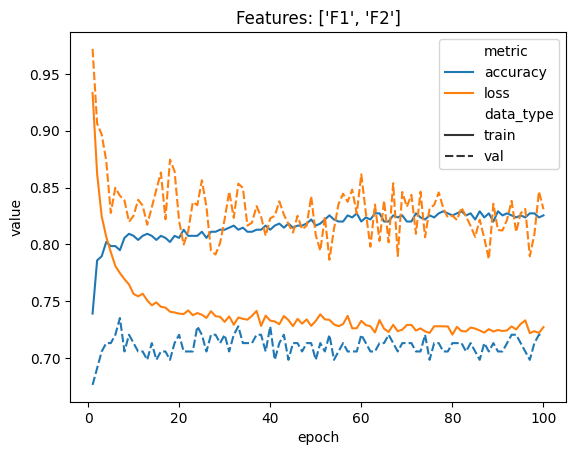

Test Error: 
 Accuracy: 74.8%, Avg loss: 0.788701 



In [4]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

### Set up the data
use_features = ['F1', 'F2']

train_dataset = CustomFormantDataset('/content/Train.pkl', use_features = use_features)
validation_dataset = CustomFormantDataset('/content/Validation.pkl', use_features = use_features)
test_dataset = CustomFormantDataset('/content/Test.pkl', use_features = use_features)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

### Set up the model
epochs = 100

model = NeuralNetwork(input_dim=len(use_features)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

validation_results = []

### Do the training
for t in tqdm(range(epochs), desc='Epochs'):
    train(train_dataloader, model, loss_fn, optimizer)
    train_corr, train_loss = test(train_dataloader, model, loss_fn)
    val_corr, val_loss = test(validation_dataloader, model, loss_fn)
    validation_results.append([t+1, 'accuracy', train_corr, 'train'])
    validation_results.append([t+1, 'loss', train_loss, 'train'])
    validation_results.append([t+1, 'accuracy', val_corr, 'val'])
    validation_results.append([t+1, 'loss', val_loss, 'val'])

### Plot training and validation accuracy and lost across epochs
sns.lineplot(
    pd.DataFrame(validation_results, columns=['epoch', 'metric', 'value', 'data_type']),
    x = 'epoch',
    y = 'value',
    hue = 'metric',
    style = 'data_type'
)
plt.title('Features: {}'.format(use_features))
plt.show()

### Test network on wholly unseen data
test_correct, test_loss = test(test_dataloader, model, loss_fn)
print(f"Test Error: \n Accuracy: {(100*test_correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Task 1

Increase the number of features to include "F3" and "F4" and rerun the experiments

Epochs: 100%|██████████| 100/100 [00:04<00:00, 22.47it/s]


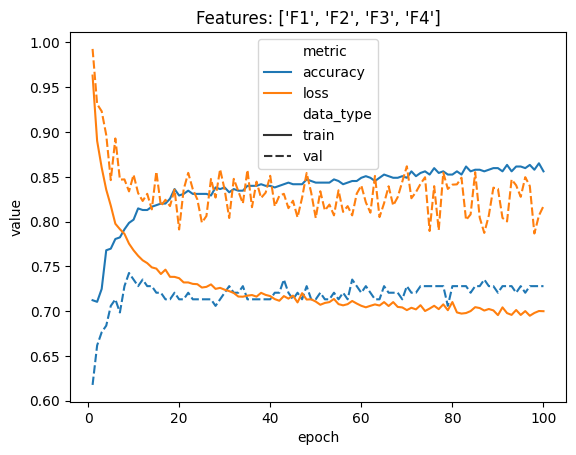

Test Error: 
 Accuracy: 77.8%, Avg loss: 0.755336 



In [5]:
use_features = ['F1', 'F2', 'F3', 'F4']

train_dataset = CustomFormantDataset('/content/Train.pkl', use_features = use_features)
validation_dataset = CustomFormantDataset('/content/Validation.pkl', use_features = use_features)
test_dataset = CustomFormantDataset('/content/Test.pkl', use_features = use_features)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

### Set up the model
epochs = 100

model = NeuralNetwork(input_dim=len(use_features)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

validation_results = []

### Do the training
for t in tqdm(range(epochs), desc='Epochs'):
    train(train_dataloader, model, loss_fn, optimizer)
    train_corr, train_loss = test(train_dataloader, model, loss_fn)
    val_corr, val_loss = test(validation_dataloader, model, loss_fn)
    validation_results.append([t+1, 'accuracy', train_corr, 'train'])
    validation_results.append([t+1, 'loss', train_loss, 'train'])
    validation_results.append([t+1, 'accuracy', val_corr, 'val'])
    validation_results.append([t+1, 'loss', val_loss, 'val'])

### Plot training and validation accuracy and lost across epochs
sns.lineplot(
    pd.DataFrame(validation_results, columns=['epoch', 'metric', 'value', 'data_type']),
    x = 'epoch',
    y = 'value',
    hue = 'metric',
    style = 'data_type'
)
plt.title('Features: {}'.format(use_features))
plt.show()

### Test network on wholly unseen data
test_correct, test_loss = test(test_dataloader, model, loss_fn)
print(f"Test Error: \n Accuracy: {(100*test_correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


### Task 2

Try also adding the bandwidths ("B1"-"B4").

Epochs: 100%|██████████| 100/100 [00:04<00:00, 23.22it/s]


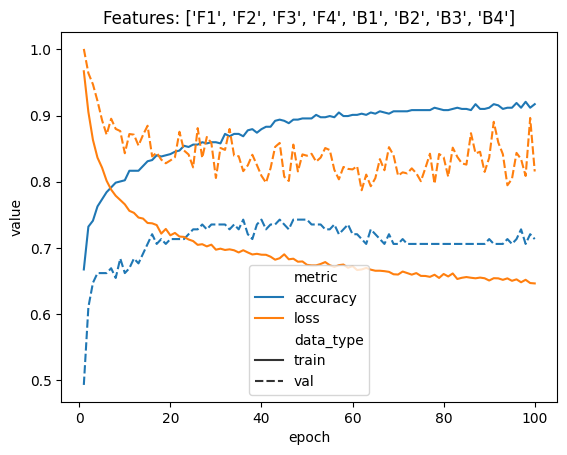

Test Error: 
 Accuracy: 74.8%, Avg loss: 0.764921 



In [6]:
use_features = ['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']

train_dataset = CustomFormantDataset('/content/Train.pkl', use_features = use_features)
validation_dataset = CustomFormantDataset('/content/Validation.pkl', use_features = use_features)
test_dataset = CustomFormantDataset('/content/Test.pkl', use_features = use_features)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

### Set up the model
epochs = 100

model = NeuralNetwork(input_dim=len(use_features)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

validation_results = []

### Do the training
for t in tqdm(range(epochs), desc='Epochs'):
    train(train_dataloader, model, loss_fn, optimizer)
    train_corr, train_loss = test(train_dataloader, model, loss_fn)
    val_corr, val_loss = test(validation_dataloader, model, loss_fn)
    validation_results.append([t+1, 'accuracy', train_corr, 'train'])
    validation_results.append([t+1, 'loss', train_loss, 'train'])
    validation_results.append([t+1, 'accuracy', val_corr, 'val'])
    validation_results.append([t+1, 'loss', val_loss, 'val'])

### Plot training and validation accuracy and lost across epochs
sns.lineplot(
    pd.DataFrame(validation_results, columns=['epoch', 'metric', 'value', 'data_type']),
    x = 'epoch',
    y = 'value',
    hue = 'metric',
    style = 'data_type'
)
plt.title('Features: {}'.format(use_features))
plt.show()

### Test network on wholly unseen data
test_correct, test_loss = test(test_dataloader, model, loss_fn)
print(f"Test Error: \n Accuracy: {(100*test_correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Task 3

Change the number of nodes in the hidden layer and see how the results change.

Epochs: 100%|██████████| 100/100 [00:04<00:00, 21.07it/s]


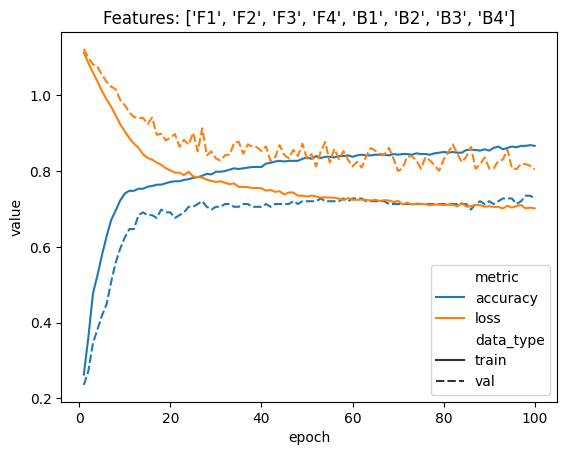

Test Error: 
 Accuracy: 72.6%, Avg loss: 0.811684 



In [7]:
#Defining a subclass for the neural network for this task to tune the
# Number of nodes locally in this cell


class NeuralNetwork_Task3(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits



use_features = ['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']

train_dataset = CustomFormantDataset('/content/Train.pkl', use_features = use_features)
validation_dataset = CustomFormantDataset('/content/Validation.pkl', use_features = use_features)
test_dataset = CustomFormantDataset('/content/Test.pkl', use_features = use_features)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

### Set up the model
epochs = 100

model = NeuralNetwork_Task3(input_dim=len(use_features)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

validation_results = []

### Do the training
for t in tqdm(range(epochs), desc='Epochs'):
    train(train_dataloader, model, loss_fn, optimizer)
    train_corr, train_loss = test(train_dataloader, model, loss_fn)
    val_corr, val_loss = test(validation_dataloader, model, loss_fn)
    validation_results.append([t+1, 'accuracy', train_corr, 'train'])
    validation_results.append([t+1, 'loss', train_loss, 'train'])
    validation_results.append([t+1, 'accuracy', val_corr, 'val'])
    validation_results.append([t+1, 'loss', val_loss, 'val'])

### Plot training and validation accuracy and lost across epochs
sns.lineplot(
    pd.DataFrame(validation_results, columns=['epoch', 'metric', 'value', 'data_type']),
    x = 'epoch',
    y = 'value',
    hue = 'metric',
    style = 'data_type'
)
plt.title('Features: {}'.format(use_features))
plt.show()

### Test network on wholly unseen data
test_correct, test_loss = test(test_dataloader, model, loss_fn)
print(f"Test Error: \n Accuracy: {(100*test_correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


#Changing the number of nodes in the hidden layers from 256 to 512(double),
# yielded the same Accuracy, but smaller avg loss
# 0.016 percentage points smaller, when doubling again(1024), the average loss
#starts increasing (maybe overfitting)

#Deacreasing the number of nodes to 128 yields almost identical avg loss as 256,
# But the Accuracy Decreases.

#Doing a more extreme test: 16 nodes vs 256 nodes vs 4096 nodes
#16 nodes:



### Task 4

Add multiple layers to the network and observe the results

Epochs: 100%|██████████| 100/100 [00:04<00:00, 21.25it/s]


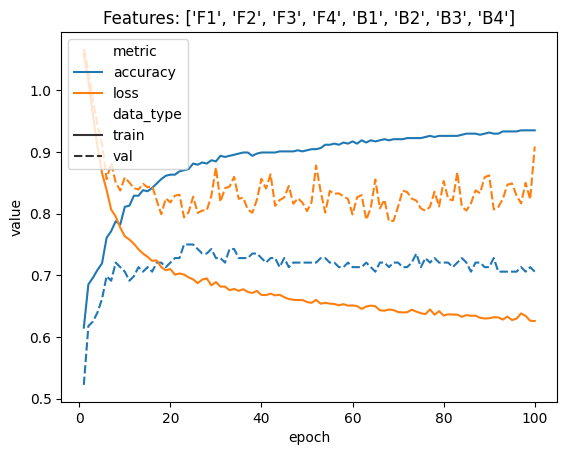

Test Error: 
 Accuracy: 75.6%, Avg loss: 0.765457 



In [8]:
#Defining a subclass for the neural network for this task to tune the
# Number of nodes locally in this cell


class NeuralNetwork_Task4(nn.Module):
    def __init__(self, input_dim, n = 64):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, n),
            nn.ReLU(),
            nn.Linear(n, 32),    #Some new layers
            nn.ReLU(),
            nn.Linear(32, 3),
            nn.Softmax(dim=1)
         )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits



use_features = ['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']

train_dataset = CustomFormantDataset('/content/Train.pkl', use_features = use_features)
validation_dataset = CustomFormantDataset('/content/Validation.pkl', use_features = use_features)
test_dataset = CustomFormantDataset('/content/Test.pkl', use_features = use_features)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

### Set up the model
epochs = 100

model = NeuralNetwork_Task4(input_dim=len(use_features)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

validation_results = []

### Do the training
for t in tqdm(range(epochs), desc='Epochs'):
    train(train_dataloader, model, loss_fn, optimizer)
    train_corr, train_loss = test(train_dataloader, model, loss_fn)
    val_corr, val_loss = test(validation_dataloader, model, loss_fn)
    validation_results.append([t+1, 'accuracy', train_corr, 'train'])
    validation_results.append([t+1, 'loss', train_loss, 'train'])
    validation_results.append([t+1, 'accuracy', val_corr, 'val'])
    validation_results.append([t+1, 'loss', val_loss, 'val'])

### Plot training and validation accuracy and lost across epochs
sns.lineplot(
    pd.DataFrame(validation_results, columns=['epoch', 'metric', 'value', 'data_type']),
    x = 'epoch',
    y = 'value',
    hue = 'metric',
    style = 'data_type'
)
plt.title('Features: {}'.format(use_features))
plt.show()

### Test network on wholly unseen data
test_correct, test_loss = test(test_dataloader, model, loss_fn)
print(f"Test Error: \n Accuracy: {(100*test_correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Task 5

 Try using dropout, and observe the results.

Epochs: 100%|██████████| 100/100 [00:05<00:00, 17.71it/s]


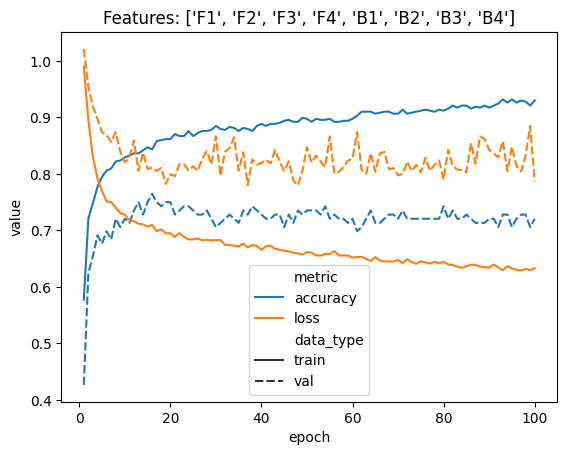

Test Error: 
 Accuracy: 76.3%, Avg loss: 0.816518 



In [9]:
class NeuralNetwork_Task5(nn.Module):
    def __init__(self, input_dim, n = 128):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, n),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(n, n),    #Some new layers
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(n, 3),
            nn.Softmax(dim=1)
         )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits



use_features = ['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']

train_dataset = CustomFormantDataset('/content/Train.pkl', use_features = use_features)
validation_dataset = CustomFormantDataset('/content/Validation.pkl', use_features = use_features)
test_dataset = CustomFormantDataset('/content/Test.pkl', use_features = use_features)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

### Set up the model
epochs = 100

model = NeuralNetwork_Task5(input_dim=len(use_features)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

validation_results = []

### Do the training
for t in tqdm(range(epochs), desc='Epochs'):
    train(train_dataloader, model, loss_fn, optimizer)
    train_corr, train_loss = test(train_dataloader, model, loss_fn)
    val_corr, val_loss = test(validation_dataloader, model, loss_fn)
    validation_results.append([t+1, 'accuracy', train_corr, 'train'])
    validation_results.append([t+1, 'loss', train_loss, 'train'])
    validation_results.append([t+1, 'accuracy', val_corr, 'val'])
    validation_results.append([t+1, 'loss', val_loss, 'val'])

### Plot training and validation accuracy and lost across epochs
sns.lineplot(
    pd.DataFrame(validation_results, columns=['epoch', 'metric', 'value', 'data_type']),
    x = 'epoch',
    y = 'value',
    hue = 'metric',
    style = 'data_type'
)
plt.title('Features: {}'.format(use_features))
plt.show()

### Test network on wholly unseen data
test_correct, test_loss = test(test_dataloader, model, loss_fn)
print(f"Test Error: \n Accuracy: {(100*test_correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Task 6

Use the data to predict the gender of the speaker. Try including the formant bandwidths as features as well ("B1"-"B4")

Epochs: 100%|██████████| 100/100 [00:05<00:00, 19.53it/s]


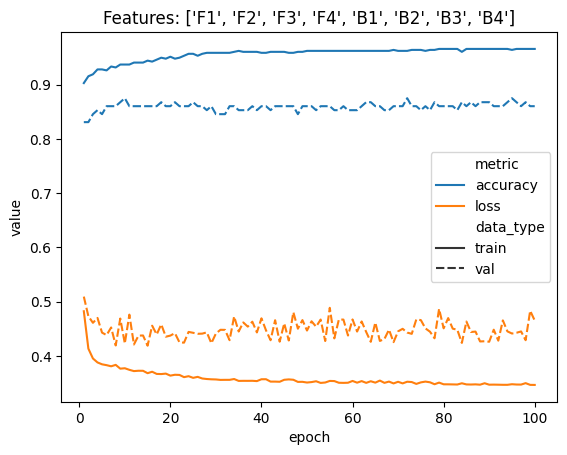

Test Error: 
 Accuracy: 88.1%, Avg loss: 0.437498 

Correctly classified: 119 of 135


In [10]:
class NeuralNetwork_Task5(nn.Module):
    def __init__(self, input_dim, n = 128):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, n),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(n, n),    #Some new layers
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(n, 2),
            nn.Softmax(dim=1)
         )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits



use_features = ['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']

train_dataset = CustomFormantDataset('/content/Train.pkl', use_features = use_features, phoneme_column = 'Gender')
validation_dataset = CustomFormantDataset('/content/Validation.pkl', use_features = use_features, phoneme_column = 'Gender')#added genders here
test_dataset = CustomFormantDataset('/content/Test.pkl', use_features = use_features, phoneme_column = 'Gender')

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

### Set up the model
epochs = 100

model = NeuralNetwork_Task5(input_dim=len(use_features)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

validation_results = []

### Do the training
for t in tqdm(range(epochs), desc='Epochs'):
    train(train_dataloader, model, loss_fn, optimizer)
    train_corr, train_loss = test(train_dataloader, model, loss_fn)
    val_corr, val_loss = test(validation_dataloader, model, loss_fn)
    validation_results.append([t+1, 'accuracy', train_corr, 'train'])
    validation_results.append([t+1, 'loss', train_loss, 'train'])
    validation_results.append([t+1, 'accuracy', val_corr, 'val'])
    validation_results.append([t+1, 'loss', val_loss, 'val'])

### Plot training and validation accuracy and lost across epochs
sns.lineplot(
    pd.DataFrame(validation_results, columns=['epoch', 'metric', 'value', 'data_type']),
    x = 'epoch',
    y = 'value',
    hue = 'metric',
    style = 'data_type'
)
plt.title('Features: {}'.format(use_features))
plt.show()

### Test network on wholly unseen data
test_correct, test_loss = test(test_dataloader, model, loss_fn)
print(f"Test Error: \n Accuracy: {(100*test_correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
num_correct = test_correct * len(test_dataset)
print(f"Correctly classified: {num_correct:.0f} of {len(test_dataset)}")




## Part B: Regression

Regression analysis is used to estimate/measure the relationship between an _independent_ variable, say $x$, and a _dependent_ variable, say $y$. One of the simplest regression problems is
\begin{equation}
y = ax + b
\end{equation}
where $a$ and $b$ are constants. In practice our observations will be contaminated by noise, so we have
\begin{equation}
y = ax + b + n,
\end{equation}
where $n$ is noise, eg. measurement errors. This particular problem is called _linear regression_.

We will have a look at _non-linear regression_, using deep neural networks. Here we are looking at general regression problems in the form
\begin{equation}
y = f(x) + n.
\end{equation}

We generate our data according to the function $f(x) = x^2 + \cos(20x) \text{ sign}(x)$, obtaining a set of observations $\{(x_i,y_i)\}$.

Then we assume we do not know the underlying function and we try to recover and approximation of $f$ only using the observations $\{(x_i,y_i)\}$.

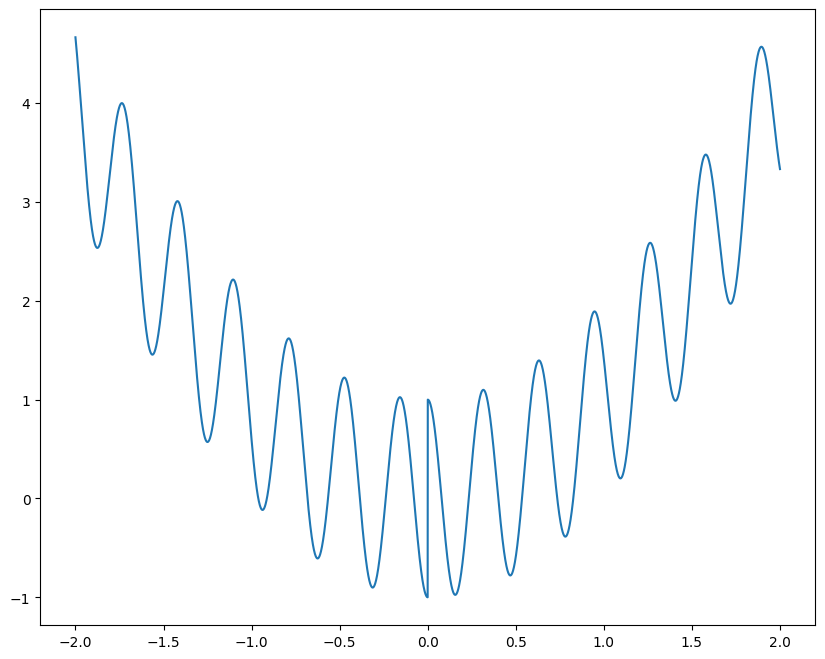

In [11]:
import numpy as np

# Define function
def f(x):
    return x**2 + np.cos(20*x)*np.sign(x)

# Setup some simulation parameters
# Number of observations
N = 5000

# Plot a "clean" version of the relationship between x and y
plt.figure(figsize=(10, 8))
x = np.linspace(-2,2,N)
plt.plot(x,f(x))
plt.show()

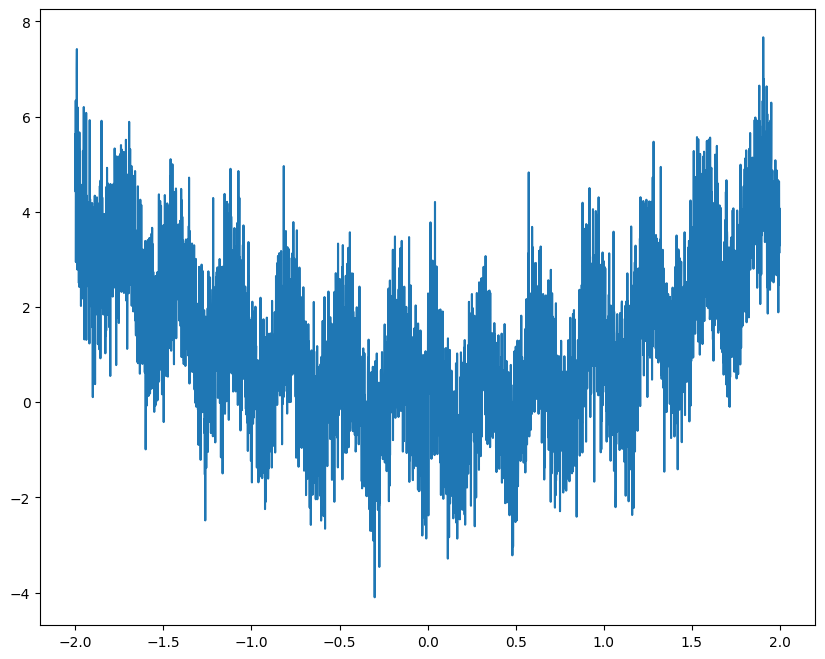

In [12]:
# Create a noise version of the observations
y = f(x) + np.random.randn(len(x))
plt.figure(figsize=(10, 8))
plt.plot(x,y)
plt.show()

One way to perform regression is to assume that the data is generated using a set of functions from a cerain family, for example polynomials of order $p$,
\begin{equation}
\hat f(x) = a_0 + a_1 x + a_2 x^2 \ldots a_p x^p.
\end{equation}
Then regression corresponds to fitting the parameters in the model. Let us see how this works out before using our neural networks.

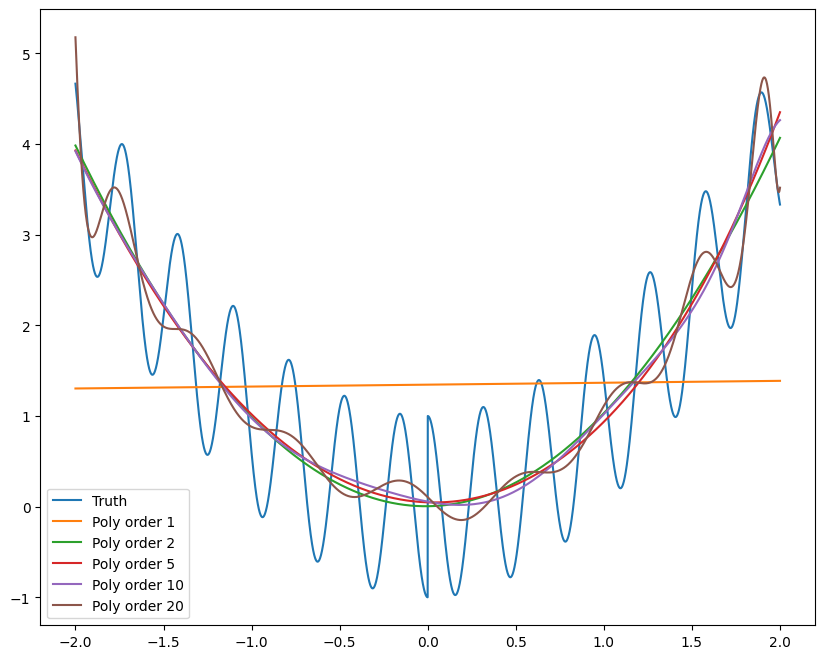

In [13]:
# Give a set of polynomial orders to try
P = [1, 2, 5, 10, 20]

# Define estimator function. Arguments are inout variable, observation and polynomial order
# Returns a set of polynomial coefficients
def reg_estimator(x,y,p):
    # Use simple ls approach
    N = len(x)
    H = np.zeros((N,p+1))
    for col in range(p+1):
        H[:,col] = x**col
    iHtH = np.linalg.inv(np.dot(H.T,H))
    theta = np.dot(np.dot(iHtH,H.T),y)
    return theta

# Computes fx) = c_0 + c_1x + c_2 x^2 ... c_p x^p
def poly(x, C):
    # compute p(x) for coeffs in c
    y = 0*x
    for p, c in enumerate(C):
        y += c*x**p
    return y

plt.figure(figsize=(10,8))
plt.plot(x,f(x),label="Truth")
for p in P:
    C = reg_estimator(x,y,p)
    plt.plot(x,poly(x,C),label="Poly order " + str(p))
plt.legend()
plt.show()

### Task 8

Play with different $p$ to see how close you can get to the true function.

Note: Very high $p$ will give numerical problems.

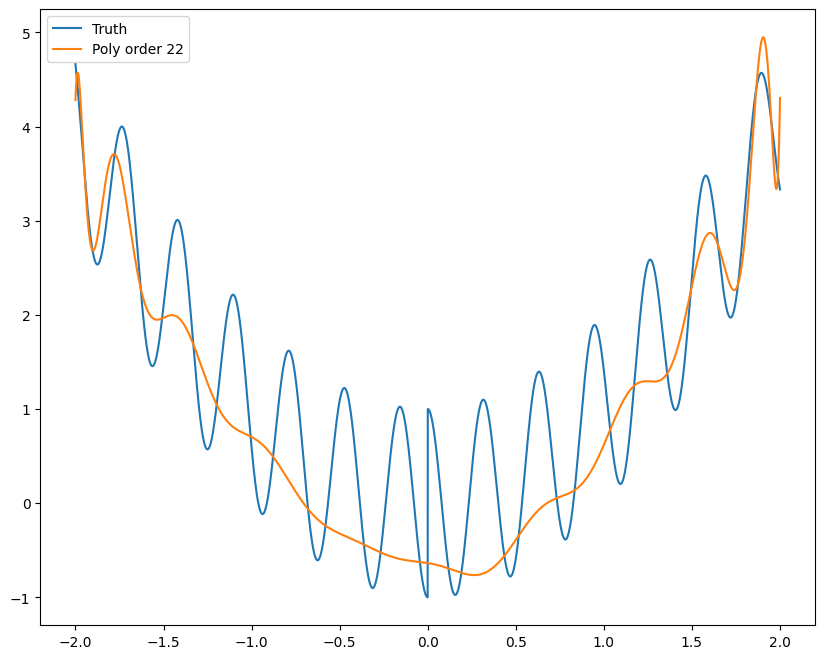

In [14]:
P = [22]

plt.figure(figsize=(10,8))
plt.plot(x,f(x),label="Truth")
for p in P:
    C = reg_estimator(x,y,p)
    plt.plot(x,poly(x,C),label="Poly order " + str(p))
plt.legend()
plt.show()

#After p = 23 the numerical errors start showing, and even at p = 23, the approximation is not very good

In what follows we will use a deep neural network to approximate $f$.

We train the network by using $x$ as an input and the squared error between the network output $\hat y$ and the observed value $y$ as a loss
\begin{equation}
 L = \frac{1}{N} \sum_n (\hat y - y)^2
\end{equation}

We first try our network on clean data to check if it works.

Using cuda device


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


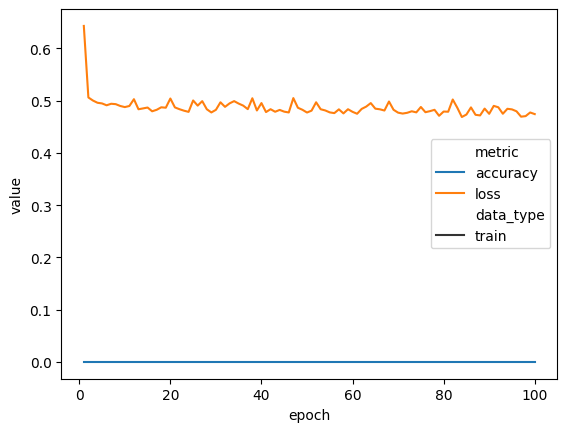

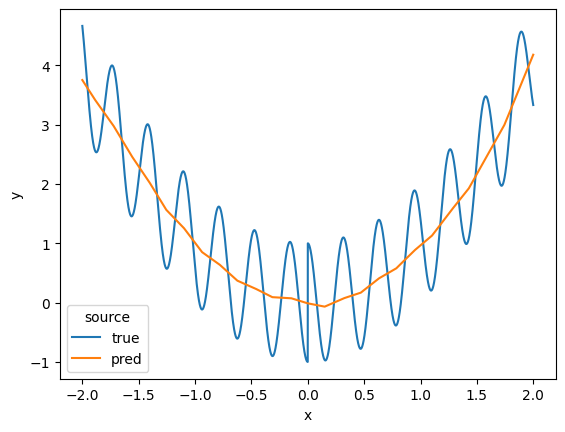

In [15]:
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor


# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

#From this point on I switched to GPU to save time as the running time on the last few tasks

class CustomSineDataset(Dataset):
    def __init__(
        self,
        x: np.array,
        y: np.array
    ):
        self.x = torch.from_numpy(x).unsqueeze(1).float()
        self.y = torch.from_numpy(y).unsqueeze(1).float()

    def __len__(self):
        return len(x)

    def __getitem__(self, idx):
        label = self.y[idx]
        data = self.x[idx]
        return data, label

# Define model
class NeuralNetwork_task8(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

def train(dataloader, model, loss_fn, optimizer, verbose=False):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if verbose:
          if batch % 100 == 0:
              loss, current = loss.item(), (batch + 1) * len(X)
              print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn, verbose=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    if verbose:
      print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

x = np.linspace(-2,2,N)
train_dataset = CustomSineDataset(x, f(x))
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

### Set up the model
epochs = 100

model = NeuralNetwork_task8(input_dim=1).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

validation_results = []

### Do the training
for t in tqdm(range(epochs), desc='Epochs'):
    train(train_dataloader, model, loss_fn, optimizer)
    train_corr, train_loss = test(train_dataloader, model, loss_fn)
    validation_results.append([t+1, 'accuracy', train_corr, 'train'])
    validation_results.append([t+1, 'loss', train_loss, 'train'])

### Plot training and validation accuracy and lost across epochs
sns.lineplot(
    pd.DataFrame(validation_results, columns=['epoch', 'metric', 'value', 'data_type']),
    x = 'epoch',
    y = 'value',
    hue = 'metric',
    style = 'data_type'
)
plt.show()

with torch.no_grad():
  x_t = torch.from_numpy(x).unsqueeze(1).float().to(device)
  model_y = model(x_t).cpu().numpy().squeeze()

df_vals = [ent for ent in zip(x, f(x), ['true'] * len(x))]

df_vals.extend([ent for ent in zip(x, model_y, ['pred'] * len(x))])

sns.lineplot(
    pd.DataFrame([{'x' : x_val, 'y' : y_val, 'source' : source} for x_val, y_val, source in df_vals]),
    x = 'x',
    y = 'y',
    hue = 'source'
)
plt.show()


### Task 9

Try increasing the number of nodes in the network to see if the results can be improved.

Using cuda device


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.09it/s]


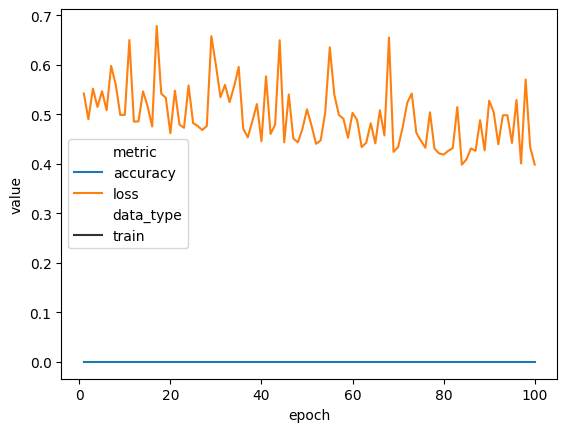

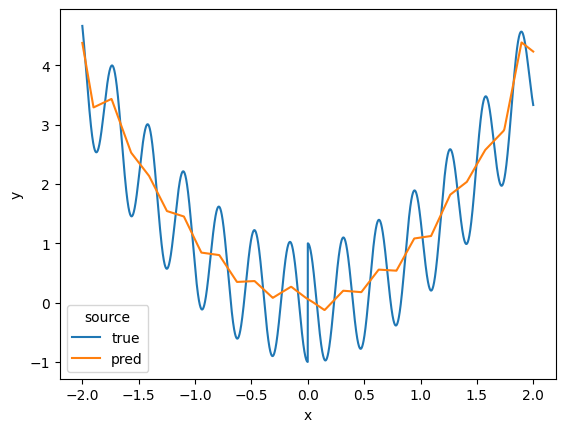

Average training loss: 0.39826662838459015


In [16]:
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor


# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class CustomSineDataset(Dataset):
    def __init__(
        self,
        x: np.array,
        y: np.array
    ):
        self.x = torch.from_numpy(x).unsqueeze(1).float()
        self.y = torch.from_numpy(y).unsqueeze(1).float()

    def __len__(self):
        return len(x)

    def __getitem__(self, idx):
        label = self.y[idx]
        data = self.x[idx]
        return data, label

# Define model
class NeuralNetwork_task9(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

def train(dataloader, model, loss_fn, optimizer, verbose=False):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if verbose:
          if batch % 100 == 0:
              loss, current = loss.item(), (batch + 1) * len(X)
              print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn, verbose=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    if verbose:
      print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

x = np.linspace(-2,2,N)
train_dataset = CustomSineDataset(x, f(x))
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

### Set up the model
epochs = 100

model = NeuralNetwork_task9(input_dim=1).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

validation_results = []

### Do the training
for t in tqdm(range(epochs), desc='Epochs'):
    train(train_dataloader, model, loss_fn, optimizer)
    train_corr, train_loss = test(train_dataloader, model, loss_fn)
    validation_results.append([t+1, 'accuracy', train_corr, 'train'])
    validation_results.append([t+1, 'loss', train_loss, 'train'])

### Plot training and validation accuracy and lost across epochs
sns.lineplot(
    pd.DataFrame(validation_results, columns=['epoch', 'metric', 'value', 'data_type']),
    x = 'epoch',
    y = 'value',
    hue = 'metric',
    style = 'data_type'
)
plt.show()

with torch.no_grad():
  x_t = torch.from_numpy(x).unsqueeze(1).float().to(device)
  model_y = model(x_t).cpu().numpy().squeeze()

df_vals = [ent for ent in zip(x, f(x), ['true'] * len(x))]

df_vals.extend([ent for ent in zip(x, model_y, ['pred'] * len(x))])

sns.lineplot(
    pd.DataFrame([{'x' : x_val, 'y' : y_val, 'source' : source} for x_val, y_val, source in df_vals]),
    x = 'x',
    y = 'y',
    hue = 'source'
)
plt.show()

print(f'Average training loss:', train_loss)


Next we will use a deep network with more than one hidden layer.

Epochs: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


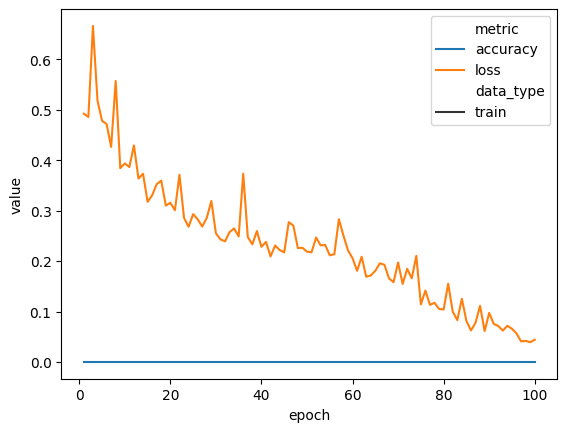

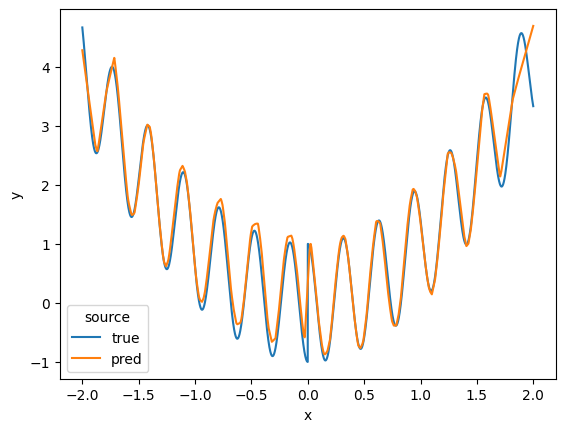

Average loss: {0.04403721508570015}


In [17]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

x = np.linspace(-2,2,N)
train_dataset = CustomSineDataset(x, f(x))
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

### Set up the model
epochs = 100

model = NeuralNetwork(input_dim=1).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

validation_results = []

### Do the training
for t in tqdm(range(epochs), desc='Epochs'):
    train(train_dataloader, model, loss_fn, optimizer)
    train_corr, train_loss = test(train_dataloader, model, loss_fn)
    validation_results.append([t+1, 'accuracy', train_corr, 'train'])
    validation_results.append([t+1, 'loss', train_loss, 'train'])

### Plot training and validation accuracy and lost across epochs
sns.lineplot(
    pd.DataFrame(validation_results, columns=['epoch', 'metric', 'value', 'data_type']),
    x = 'epoch',
    y = 'value',
    hue = 'metric',
    style = 'data_type'
)
plt.show()

with torch.no_grad():
  x_t = torch.from_numpy(x).unsqueeze(1).float().to(device)
  model_y = model(x_t).cpu().numpy().squeeze()

df_vals = [ent for ent in zip(x, f(x), ['true'] * len(x))]

df_vals.extend([ent for ent in zip(x, model_y, ['pred'] * len(x))])

sns.lineplot(
    pd.DataFrame([{'x' : x_val, 'y' : y_val, 'source' : source} for x_val, y_val, source in df_vals]),
    x = 'x',
    y = 'y',
    hue = 'source'
)
plt.show()
print(f'Average loss:', {train_loss})

### Task 10

Try increasing the number of hidden nodes per layer until performance is satisfactory. Can the same effect be achieved by just adding more layers?

Epochs: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


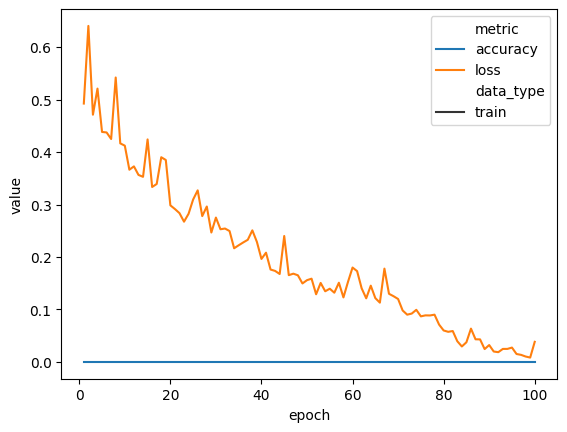

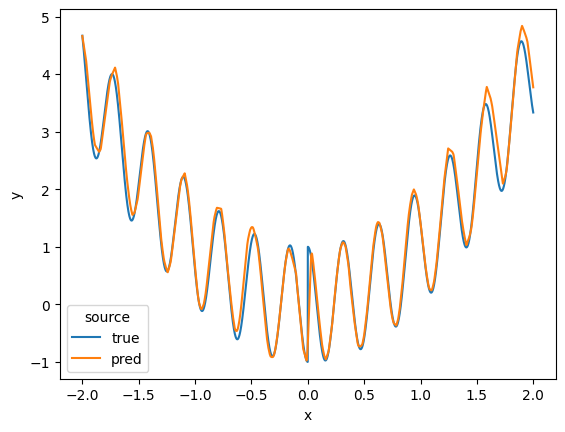

Average loss: {0.03830649252049625}


In [18]:
# Define model

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 800),
            nn.ReLU(),
            nn.Linear(800, 800),
            nn.ReLU(),
            nn.Linear(800, 800),
            nn.ReLU(),
            nn.Linear(800, 800),
            nn.ReLU(),
            nn.Linear(800, 1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

x = np.linspace(-2,2,N)
train_dataset = CustomSineDataset(x, f(x))
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

### Set up the model
epochs = 100

model = NeuralNetwork(input_dim=1).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

validation_results = []

### Do the training
for t in tqdm(range(epochs), desc='Epochs'):
    train(train_dataloader, model, loss_fn, optimizer)
    train_corr, train_loss = test(train_dataloader, model, loss_fn)
    validation_results.append([t+1, 'accuracy', train_corr, 'train'])
    validation_results.append([t+1, 'loss', train_loss, 'train'])

### Plot training and validation accuracy and lost across epochs
sns.lineplot(
    pd.DataFrame(validation_results, columns=['epoch', 'metric', 'value', 'data_type']),
    x = 'epoch',
    y = 'value',
    hue = 'metric',
    style = 'data_type'
)
plt.show()
with torch.no_grad():
  x_t = torch.from_numpy(x).unsqueeze(1).float().to(device)
  model_y = model(x_t).cpu().numpy().squeeze()

df_vals = [ent for ent in zip(x, f(x), ['true'] * len(x))]

df_vals.extend([ent for ent in zip(x, model_y, ['pred'] * len(x))])

sns.lineplot(
    pd.DataFrame([{'x' : x_val, 'y' : y_val, 'source' : source} for x_val, y_val, source in df_vals]),
    x = 'x',
    y = 'y',
    hue = 'source'
)
plt.show()
print(f'Average loss:', {train_loss})

### Task 11

Using the best setup from the previous problem, train a model using the noisy data.

Epochs: 100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


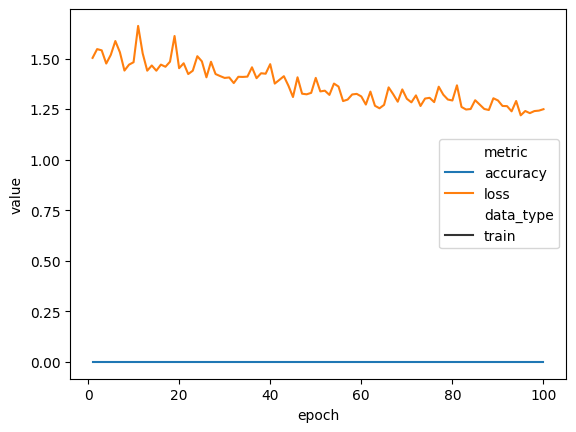

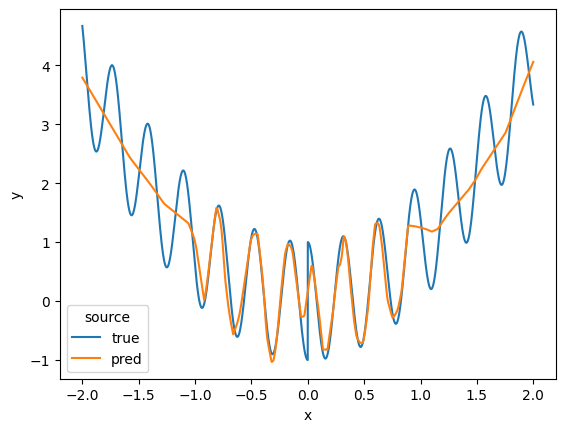

Average loss: {1.2496037632226944}


In [23]:
# Define model

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 800),
            nn.ReLU(),
            nn.Linear(800, 800),
            nn.ReLU(),
            nn.Linear(800, 800),
            nn.ReLU(),
            nn.Linear(800, 800),
            nn.ReLU(),
            nn.Linear(800, 1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

x = np.linspace(-2,2,N)
train_dataset = CustomSineDataset(x, y)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

### Set up the model
epochs = 100

model = NeuralNetwork(input_dim=1).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

validation_results = []

### Do the training
for t in tqdm(range(epochs), desc='Epochs'):
    train(train_dataloader, model, loss_fn, optimizer)
    train_corr, train_loss = test(train_dataloader, model, loss_fn)
    validation_results.append([t+1, 'accuracy', train_corr, 'train'])
    validation_results.append([t+1, 'loss', train_loss, 'train'])

### Plot training and validation accuracy and lost across epochs
sns.lineplot(
    pd.DataFrame(validation_results, columns=['epoch', 'metric', 'value', 'data_type']),
    x = 'epoch',
    y = 'value',
    hue = 'metric',
    style = 'data_type'
)
plt.show()
with torch.no_grad():
  x_t = torch.from_numpy(x).unsqueeze(1).float().to(device)
  model_y = model(x_t).cpu().numpy().squeeze()

df_vals = [ent for ent in zip(x, f(x), ['true'] * len(x))]

df_vals.extend([ent for ent in zip(x, model_y, ['pred'] * len(x))])

sns.lineplot(
    pd.DataFrame([{'x' : x_val, 'y' : y_val, 'source' : source} for x_val, y_val, source in df_vals]),
    x = 'x',
    y = 'y',
    hue = 'source'
)
plt.show()
print(f'Average loss:', {train_loss})